### Clustering using PseAAC features

##### <u> Part 1: Extracting protein sequence data </u>

In [344]:
import re

class CAZy_data:
    def __init__(self,filename1,filename2):
        self.data,self.acc,self.seq=[],[],[]
        with open(filename1,'r') as inpt:
            for each in inpt:
                self.data.append(each.rstrip().split('$'))
        with open(filename2,'r') as inpt1:
            for each1 in inpt1:
                if each1.startswith('>'):
                    self.acc.append(each1.rstrip())
                else:
                    self.seq.append(each1.rstrip())
            
                  
    def data_fetch(self,typ,position):
        typ_data=[]
        if typ=='all':
            typ_data=self.data
        else:
            for each in self.data:
                mult=each[position].split(' ')
                if len(mult)==1:#### In case typ = EC, Multi EC number and protein with no EC number are ignore.
                    if mult[0]==typ:
                        typ_data.append(each)
        return typ_data
    
    def EC_GH(self,ec_no,gh_fam):
        self.fasta=[]
        cazy_ec=self.data_fetch(ec_no,1)
        cazy_gh=self.data_fetch(gh_fam,-1)
        self.common_data=[[i[0],i[1],i[2],i[3],i[-2],i[-1]] for i in cazy_ec if i in cazy_gh]
        rm_prt=0
        for each in range(len(self.common_data)):
            t=self.common_data[each]
            if self.prtn_filter(t[0]):
                all_acc=t[3].split(' ')
                if all_acc[0]!='':
                    for e_acc in all_acc:
                        e_seq=self.seq_fetch(e_acc)
                        try:
                            create_error=0/len(e_seq) # to remove accession number which doesnt have hits
                            self.fasta.append(f'>{e_acc}${t[0]}${t[1]}${t[2]}${t[-2]}${t[-1]}')
                            self.fasta.append(e_seq[0])
                        except ZeroDivisionError:
                            pass
            else:
                rm_prt+=1             
        print('Number of removed partial or fragment proteins:',rm_prt) 
        return self.fasta
    def prtn_filter(self,prt_name):
        hit=1
        if re.search('partial|fragment',prt_name.lower()):
            hit-=1
        return hit
            
    def seq_fetch(self,accession):
        hits=[]
        for each in range(len(self.acc)):
            if re.search(f'{accession}\D',self.acc[each]):
                hits.append(self.seq[each])
        if len(hits)>1:
            print(f'Multiple hits for {accession}')
        elif len(hits)==0:
            print(f'No hits for {accession}')
        return hits
     
In_data=CAZy_data('D:/before_4_4_22/cazy_data/char_gh/char_cazy_12_8_21.txt','D:/before_4_4_22/cazy_data/char_gh/char_gh_seq_nr.txt')

In [629]:
ec_number='3.2.1.17'
gh_family='all'
cazy_acc_seq=In_data.EC_GH(ec_number,gh_family) # write all to fetch all the EC number or all the GH family

Number of removed partial or fragment proteins: 7


##### <u> Part 2: Extracting feature from protein sequences </u>

In [589]:
import numpy as np
from scipy import stats
import pandas as pd

# 1: Hydrophobicity, 2: Hydrophilicity, 3: mass, 4: pk1, 5:pk2, 6:pi, 20: 14 scale, 60: Tanford
class Standard_values:
    def __init__(self,filename):
        self.data=[]
        with open(filename,'r') as inpt:
            for each in inpt:
                self.data.append(each.rstrip().split(','))
        del self.data[0]
        
    def get_prop(self,prop):
        got_prop,amino_acid={},{}
        for each in prop:
            got_prop[each]=self.properties(each)
        d=1
        for each in got_prop[1].keys():
            amino_acid[d]=each
            d+=1
        return amino_acid,got_prop
    
    def properties(self, val):
        temp,norm={},{}
        for each in self.data:
            temp[each[0]]=float(each[val])
        relative=stats.zscore(np.array(list(temp.values())))
        for a,b in zip(temp.keys(),relative):
            norm[a]=b
        return norm

class Sequence:
    def __init__(self,filename):
        self.data=[]
        if type(filename)==str:
            with open(filename,'r') as inpt:
                for each in inpt:
                    self.data.append(each.rstrip())
        else:
            self.data=filename
                       
    def output(self):
        a,s,l=[],[],[]
        unusual=0
        for ele in self.ml_sl():
            if ele.startswith('>'):
                a.append(ele.rstrip())
            else:
                if 'X' in ele:
                    ele=ele.replace('X','A') # replacing X with A amino acid as in Trembl(Ala (A) 9.26 Leu (L) 9.91)
                    unusual=+1
                l.append(len(ele.rstrip()))
                s.append(ele.rstrip().upper())
        print('The length of the smallest sequence:',min(l))
        print('Sequence with "X" present:',unusual)
        return a,s,l
             
    def ml_sl(self):
        acc_seq=[]
        for k in range(len(self.data)):
            if self.data[k].startswith('>'):
                acc_seq.append(self.data[k]+'\n')
                join_=0
                for l in range(k+1,len(self.data)):
                    if self.data[l].startswith('>') == False:
                        join_+=1
                    else:
                        break
                acc_seq.append(''.join(self.data[k+1:k+1+join_])+'\n')
        return acc_seq

class Pseaac:
    def __init__(self,filename):
        self.filename=filename
        
    def collect(self,lamb,w,pro,nf):
        if min(min_len)<=lamb:
            raise Exception(f'lambda({lamb}) should be less than minimum length({min(min_len)})')
 
        val=[]
        val.append(['#']+[ea for ea in keys.values()]+['\u03BB'+str(eac+1) for eac in range(lamb)])
        for e_seq in range(len(seq)):# single sequence taken for test
            q=self.pse(seq[e_seq],lamb,w,pro,nf)
            tem=acc[e_seq].split(' ')[0][1:]
            val.append([acc[e_seq]]+q)
        df=pd.DataFrame(val[1:],columns=val[0])
        print('PseAAC feature have been extracted!!!')
        return df
        
    def pse(self,data,lamb,w,pro,nf):
        thet=self.theta(data,lamb,pro)
        deno=1+(w*sum(thet.values()))
        p=[]
        if nf==1:
            norm=(len(data))
        else:
            norm=1
        for u in range(1,21+lamb):
            if u>=1 and u<=20:
    #             print(u,'natural')
                num=data.count(keys[u])/norm # frequency
                p.append(num/deno)
            elif u>=21 and u<=20+lamb:
    #             print(u,'pseudo')
                num=w*thet[u-20]
                p.append(num/deno)
        return p
    
    def theta(self,data,lamb,pro):
        the={}
        for u in range(1,lamb+1):
            the[u]=(1/(len(data)-u))*self.rel_cal(data,u,pro)
        return the
    
    def rel_cal(self,data,v,pro):
        tem=[]
        for u in range(len(data)-v):
            te=[]
            for u1 in pro:
                x=((values[u1][data[u]])-(values[u1][data[u+v]]))**2
                te.append(x)
    #             print(u1,u,u+v,data[u],data[u+v],x)
            tem.append(sum(te)/len(pro))
        return sum(tem)

lambda_value=20
keys,values=Standard_values('7_98_hydrophobicity.csv').get_prop([1,2,3,4,5,6,20,60])
acc,seq,min_len=Sequence(cazy_acc_seq).output()
pseaac_data=Pseaac(f'PAAC_{ec_number}_{gh_family}_L{lambda_value}.txt').collect(lambda_value,0.05,[60,2,3],1)

The length of the smallest sequence: 21
Sequence with "X" present: 1
PseAAC feature have been extracted!!!


##### <u>Part 3: Clustering</u>

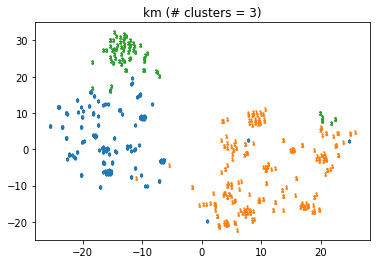

In [633]:
'''Clustering Algorithm'''
import os
import time
import matplotlib.pyplot as plt
from sklearn import cluster, mixture, manifold, decomposition, preprocessing
import random
import re
from collections import Counter,defaultdict
import copy

class clustering:
    rs=77
#     rn=random.randint(1,99)
    def __init__(self,folder,data,n,cat):
        self.n=n
        self.x=data.iloc[:,1:].values
        self.y=data.iloc[:,0]
        self.folder=folder
        self.cat=cat
        
    def kmeans(self):
        start = time.time()
        self.names = 'km'
        kmeans = cluster.KMeans(n_clusters=self.n,random_state=clustering.rs) # Number of clusters
        self.labels = kmeans.fit_predict(self.x)
        end = time.time()
        self.t = round((end-start),3)
        return self.label_save()
    
    def affinity(self):
        start = time.time()
        self.names = 'apc'
        apc = cluster.AffinityPropagation(random_state=clustering.rs)
        self.labels = apc.fit_predict(self.x)
        end = time.time()
        self.t = round((end-start),3)
        return self.label_save()
        
    def meanshift(self):
        start = time.time()
        self.names = 'ms'
        ms = cluster.MeanShift()
        self.labels = ms.fit_predict(self.x)
        end = time.time()
        self.t = round((end-start),3)
        return self.label_save()
        
    def spectral(self):
        start = time.time()
        self.names = 'spec'
        spectral = cluster.SpectralClustering(n_clusters=self.n,assign_labels="discretize",random_state=clustering.rs) # Number of clusters
        self.labels = spectral.fit_predict(self.x)
        end = time.time()
        self.t = round((end-start),3)
        return self.label_save()
        
    def agglomerative(self):
        start = time.time()
        self.names = 'agglo'
        agglo = cluster.AgglomerativeClustering(n_clusters=self.n) # Number of clusters
        self.labels = agglo.fit_predict(self.x)
        end = time.time()
        self.t = round((end-start),3)
        return self.label_save()
        
    def dbscan(self):
        start = time.time()
        self.names = 'dbs'
        new_x=preprocessing.StandardScaler().fit_transform(self.x)
        dbs = cluster.DBSCAN()
        self.labels = dbs.fit_predict(new_x)
        end = time.time()
        self.t = round((end-start),3)
        return self.label_save()
        
    def optics(self):
        start = time.time()
        self.names = 'opt'
        opt = cluster.OPTICS()
        self.labels = opt.fit_predict(self.x)
        end = time.time()
        self.t = round((end-start),3)
        return self.label_save()
        
    def gaussian(self):
        start = time.time()
        self.names = 'gm'
        gm = mixture.GaussianMixture(n_components=self.n,random_state=clustering.rs) # Number of Clusters
        self.labels = gm.fit_predict(self.x)
        end = time.time()
        self.t = round((end-start),3)
        return self.label_save()
        
    def birch(self):
        start = time.time()
        self.names = 'bir'
        brc = cluster.Birch() # Number of clusters
        self.labels = brc.fit_predict(self.x)
        end = time.time()
        self.t = round((end-start),3)
        return self.label_save()

    def label_save(self):
        dfout = pd.DataFrame({'Accession': self.y,  'Group': self.labels})
        try:
            os.mkdir(self.folder)
        except FileExistsError:
            pass
        dfout.to_csv(f'{self.folder}\ML_{self.names}_{len(set(self.labels))}.txt',sep='\t', index=False)
#         self.pca_() # Disable the PCA graph
        self.tsne_()
        return self.file()

    def pca_(self):
        pca = decomposition.PCA(n_components=2, random_state=clustering.rs)
        pca_diff=pca.fit(self.x)
        pca_axis = pca.fit_transform(self.x)
        self.graph(pca_axis,'pca')
    #     print(pca_diff.explained_variance_ratio_)

    def tsne_(self):
        tsne = manifold.TSNE(n_components=2, random_state=clustering.rs)
        tsne_axis = tsne.fit_transform(self.x)
        self.graph(tsne_axis,'tsne')

    def graph(self,axis,types):
        df_graph = pd.DataFrame({'X': axis[:, 0], 'Y': axis[:, 1], 'L': self.labels}) 
        marker={i_:f"${i_}$" for i_ in range(10)}
        n_clust=set(self.labels)
        lock=-1
        for each in n_clust:
    #         lock=random.randint(0,12)
            lock+=1
            if lock>len(marker)-1:
                lock = 0
            newdf = df_graph.loc[df_graph.loc[:, "L"] == each, :]
            plt.scatter(np.array(newdf.X), np.array(newdf.Y), 10, label=each, marker=marker[lock])
            plt.title(f'{self.names} (# clusters = {len(n_clust)})')
        plt.savefig(f'{self.folder}/{self.names}_{len(n_clust)}_{types}.png',dpi=300)
        plt.show()
        plt.close()
        
    def file(self):
        try:
            os.mkdir(f'{self.folder}/table')
        except FileExistsError:
            pass
        dd=defaultdict(list)
        for i in range(len(self.labels)):
            dd[self.labels[i]].append(self.y[i])
        return self.excel(dict(sorted(dd.items())))
        
    def excel(self,anno):
        all_anno={}
        anno_label={0:'acc',1:'prtn',2:'ec',3:'org',4:'species',5:'ghf'}
        for i in self.cat:
            temp={}
            for j,k in anno.items():
                te=[]
                for l in k:
                    te.append(l.split('$')[i])
                temp[j]=dict(Counter(te))
            df=pd.DataFrame(temp).fillna(0).astype(int)
            df.loc['Total']=df.sum(axis=0)
            df.loc[:,'Total']=df.sum(axis=1)
            df.to_excel(f'{self.folder}/table/{self.names}_{len(set(self.labels))}_{anno_label[i]}.xlsx')
        return df
ec_=ec_number.replace('.','_')
clust=clustering(f'{gh_family}_{ec_}',pseaac_data,3,[5]) # 0:'acc',1:'prtn',2:'ec',3:'org',4:'species',5:'ghf'

km=clust.kmeans()
# apc=clust.affinity()
# ms=clust.meanshift()
# spec=clust.spectral()
# agglo=clust.agglomerative()
# dbs=clust.dbscan()
# opt=clust.optics()
# gm=clust.gaussian()
# bir=clust.birch()


In [634]:
km

,0,1,2,Total
GH0,5,0,0,5
GH19,2,0,0,2
GH22,2,221,7,230
GH23,55,2,3,60
GH24,42,2,0,44
GH25,40,0,59,99
GH73,3,0,0,3
GH108,2,0,0,2
Total,151,225,69,445


In [632]:
cazy_acc_seq

['>CAA90860.1$pesticin (Pst)$3.2.1.17$Yersinia pestis 358$Bacteria$GH0',
 'MSDTMVVNGSGGVPAFLFSGSTLSSYRPNFEANSITIALPHYVDLPGRSNFKLMYIMGFPIDTEMEKDSEYSNKIRQESKISKTEGTVSYEQKITVETGQEKDGVKVYRVMVLEGTIAESIEHLDKKENEDILNNNRNRIVLADNTVINFDNISQLKEFLRRSVNIVDHDIFSSNGFEGFNPTSHFPSNPSSDYFNSTGVTFGSGVDLGQRSKQDLLNDGVPQYIADRLDGYNMLRGKEAYDKVRTAPLTLSDNEAHLLSNIYIDKFSHKIEGLFNDANIGLRFSDLPLRTRTALVSIGYQKGFKLSRTAPTVWNKVIAKDWNGLVNAFNNIVDGMSDRRKREGALVQKDIDSGLLK',
 '>CCC82852.1$pesticin (Pst)$3.2.1.17$Yersinia pestis 358$Bacteria$GH0',
 'MSDTMVVNGSGGVPAFLFSGSTLSSYRPNFEANSITIALPHYVDLPGRSNFKLMYIMGFPIDTEMEKDSEYSNKIRQESKISKTEGTVSYEQKITVETGQEKDGVKVYRVMVLEGTIAESIEHLDKKENEDILNNNRNRIVLADNTVINFDNISQLKEFLRRSVNIVDHDIFSSNGFEGFNPTSHFPSNPSSDYFNSTGVTFGSGVDLGQRSKQDLLNDGVPQYIADRLDGYYMLRGKEAYDKVRTAPLTLSDNEAHLLSNIYIDKFSXKIEGLFNDANIGLRFSDLPLRTRTALVSIGYQKGFKLSRTAPTVWNKVIAKDWNGLVNAFNNIVDGMSDRRKREGALVQKDIDSGLLK',
 '>AEL74928.1$pesticin (Pst;A1122_21767)$3.2.1.17$Yersinia pestis A1122$Bacteria$GH0',
 'MSDTMVVNGSGGVPAFLFSGSTLSSYRPNFEANSITIALPH